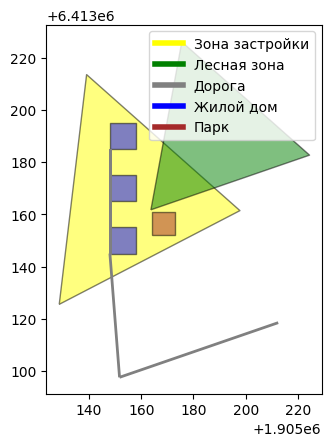

In [7]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import json
from pyproj import CRS, Transformer
from shapely.geometry import shape, Polygon, LineString, Point
from shapely.ops import transform
import networkx as nx

# Загрузка данных
with open('input.geojson') as f:
    geo_data = json.load(f)

# Преобразование GeoJSON в GeoDataFrame с извлечением свойств
features = geo_data["features"]
for feature in features:
    feature['geometry'] = shape(feature['geometry'])

gdf = gpd.GeoDataFrame(features)
gdf['name'] = gdf['properties'].apply(lambda x: x['name'])
gdf['restriction'] = gdf['properties'].apply(lambda x: x.get('restriction', None))

# Преобразование координат
wgs84 = CRS("EPSG:4326")  # Координаты в долготе и широте
utm = CRS("EPSG:32633")   # Координаты в метрах

transformer = Transformer.from_crs(wgs84, utm, always_xy=True)
gdf['geometry'] = gdf['geometry'].apply(lambda geom: transform(transformer.transform, geom))

# Ограничения по плотности застройки
max_density = 0.5  # 50%

# Минимальное расстояние между объектами для домов
min_distance = 10  # метров

# Назначение цветов для разных типов зон
color_map = {
    'Зона застройки': 'yellow',
    'Лесная зона': 'green',
    'Дорога': 'gray',
    'Жилой дом': 'blue',
    'Парк': 'brown'
}

# Функция проверки, можно ли строить в заданной точке
def can_build_at_point(polygon, gdf):
    for _, row in gdf.iterrows():
        if row['geometry'].intersects(polygon) and row['restriction'] == 'no_build':
            return False
    return True

# Функция для размещения нескольких домов с ограничением по расстоянию между строениями
def place_multiple_houses(gdf, build_zone, house_size, max_density):
    buildings = []
    build_area = build_zone.iloc[0]['geometry'].area
    max_build_area = build_area * max_density

    current_build_area = 0
    minx, miny, maxx, maxy = build_zone.total_bounds

    for x in range(int(minx), int(maxx - house_size), house_size + min_distance):
        for y in range(int(miny), int(maxy - house_size), house_size + min_distance):
            house_polygon = Polygon([(x, y), (x + house_size, y), (x + house_size, y + house_size), (x, y + house_size)])
            if build_zone.iloc[0]['geometry'].contains(house_polygon) and can_build_at_point(house_polygon, gdf):
                buildings.append(house_polygon)
                current_build_area += house_polygon.area
                if current_build_area >= max_build_area:
                    break

    return buildings

# Функция для размещения парка без учета существования лесной зоны и ограничения по расстоянию
def place_park(gdf, build_zone, park_size):
    park = None
    build_polygon = build_zone.iloc[0]['geometry']

    minx, miny, maxx, maxy = build_polygon.bounds
    for x in range(int(minx), int(maxx - park_size), park_size):
        for y in range(int(miny), int(maxy - park_size), park_size):
            park_polygon = Polygon([(x, y), (x + park_size, y), (x + park_size, y + park_size), (x, y + park_size)])
            if build_polygon.contains(park_polygon) and can_build_at_point(park_polygon, gdf):
                if not any(building.intersects(park_polygon) for building in gdf[gdf['name'] == 'Жилой дом']['geometry']):
                    park = park_polygon
                    break

    return park

# Прокладка дорог
def connect_houses_with_roads(gdf):
    roads = []
    road_network = nx.Graph()

    existing_roads = gdf[gdf['name'] == 'Дорога']['geometry']
    houses = gdf[gdf['name'] == 'Жилой дом']['geometry']

    # Создание графа дорог
    for road in existing_roads:
        for start, end in zip(road.coords[:-1], road.coords[1:]):
            road_network.add_edge(start, end, weight=Point(start).distance(Point(end)))

    def get_nearest_point(exterior, point):
        nearest_point = exterior.coords[0]
        min_distance = point.distance(Point(nearest_point))
        for coord in exterior.coords:
            dist = point.distance(Point(coord))
            if dist < min_distance:
                nearest_point = coord
                min_distance = dist
        return nearest_point

    # Подключение домов к существующим дорогам
    for house in houses:
        house_centroid = house.centroid
        nearest_road_node = min(road_network.nodes, key=lambda node: Point(node).distance(house_centroid))

        # Находим ближайшую точку на внешнем контуре дома
        house_exterior = house.exterior
        nearest_point = get_nearest_point(house_exterior, Point(nearest_road_node))

        road_network.add_edge(nearest_road_node, nearest_point, weight=Point(nearest_road_node).distance(Point(nearest_point)))
        roads.append(LineString([nearest_road_node, nearest_point]))

    # Подключение домов друг к другу
    connected_houses = set()
    for house in houses:
        house_exterior = house.exterior
        nearest_point = get_nearest_point(house_exterior, house.centroid)
        connected_houses.add(nearest_point)

        for other_house in houses:
            if house != other_house:
                other_house_exterior = other_house.exterior
                other_nearest_point = get_nearest_point(other_house_exterior, other_house.centroid)
                if nearest_point != other_nearest_point:
                    road_network.add_edge(nearest_point, other_nearest_point, weight=Point(nearest_point).distance(Point(other_nearest_point)))
                    roads.append(LineString([nearest_point, other_nearest_point]))

    return roads

# Определение зоны застройки
build_zone = gdf[gdf['name'] == 'Зона застройки']

# Размещение нескольких домов
house_size = 10  # размер дома 10 на 10 метров
buildings = place_multiple_houses(gdf, build_zone, house_size, max_density)

# Добавление объектов в GeoDataFrame
buildings_gdf = gpd.GeoDataFrame([{'geometry': building, 'name': 'Жилой дом', 'restriction': None} for building in buildings])
gdf = pd.concat([gdf, buildings_gdf], ignore_index=True)

# Размещение парка
park_size = 9  # размер парка 9 на 9 метров
park = place_park(gdf, build_zone, park_size)

if park is not None:
    park_gdf = gpd.GeoDataFrame([{'geometry': park, 'name': 'Парк', 'restriction': None}])
    gdf = pd.concat([gdf, park_gdf], ignore_index=True)

# Прокладка дорог
roads = connect_houses_with_roads(gdf)

# Добавление дорог в GeoDataFrame
roads_gdf = gpd.GeoDataFrame([{'geometry': road, 'name': 'Дорога', 'restriction': None} for road in roads])
gdf = pd.concat([gdf, roads_gdf], ignore_index=True)

# Отрисовка графика с цветами
fig, ax = plt.subplots()
for _, row in gdf.iterrows():
    geom_type = row['geometry'].geom_type
    color = color_map.get(row['name'], 'black')
    if geom_type == 'Polygon':
        gdf[gdf.geometry == row['geometry']].plot(ax=ax, color=color, edgecolor='black', alpha=0.5)
    elif geom_type == 'LineString':
        gdf[gdf.geometry == row['geometry']].plot(ax=ax, color=color, linewidth=2)


# Легенда
legend_labels = [plt.Line2D([0], [0], color=color_map[name], lw=4) for name in color_map]
legend_names = list(color_map.keys())
plt.legend(legend_labels, legend_names)

plt.show()

